Sample Length
----
This notebook will explore the sample length, and more importantly the question "can we afford to ignore sample length when splitting train/test sets by patient.

In [12]:
from utils import load_example, get_patient, get_patient_list, HealthChecker
from tqdm.notebook import tqdm
from data_eng import data_folder
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

In [2]:
hc = HealthChecker(data_folder+'CONTROLS')
lens, pats, hlth = [], [], []
paths = list(Path(data_folder).rglob('*.hea'))
for path in tqdm(paths):
    lens.append(load_example(path)[1]['sig_len'])
    pats.append(get_patient(path))
    hlth.append(hc.healthy_sample(path))
df = pd.DataFrame({"length": lens, "patient": pats, "class": hlth})

In [3]:
df.head()

,length,patient,class
0,115200,104,1
1,115200,174,1
2,115200,174,1
3,115200,174,1
4,115200,63,0


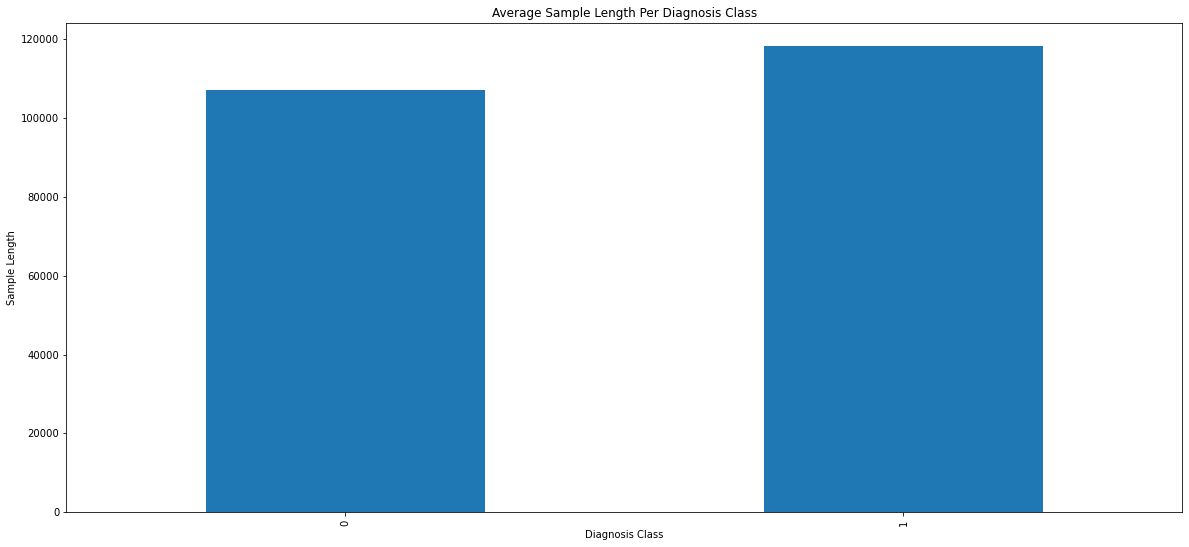

In [39]:
fig, ax = plt.subplots(figsize=(20,9))
df.groupby('class').length.mean().plot(ax=ax, kind='bar')
ax.set_title('Average Sample length per diagnosis class'.title())
ax.set_ylabel('Sample Length')
ax.set_xlabel('Diagnosis Class')
plt.show()

Text(0.5, 1.0, 'Distribution Of Signal Lengths Per Patient')

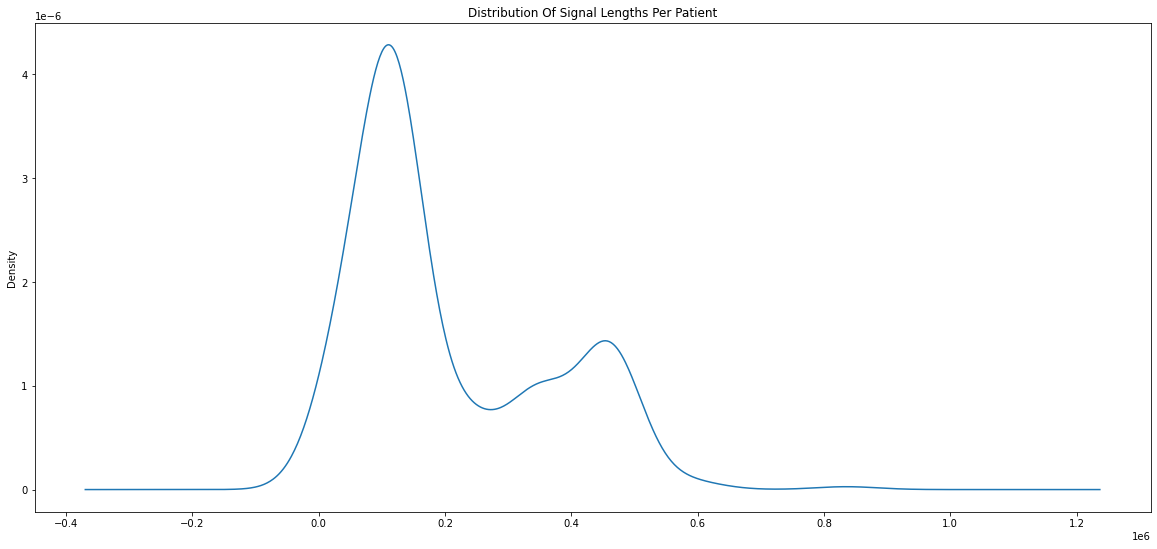

In [49]:
ax = df.groupby('patient').length.sum().plot(kind='kde', figsize=(20, 9))
ax.set_title("Distribution of signal lengths per patient".title())

### Check if per patient samples are homogenously diagnosed or mixed:

In [40]:
pclass = df.groupby('patient')['class'].mean()
pclass.value_counts().head()

0    238
1     52
Name: class, dtype: int64

From the above it's safe to say they're all homogenously diagnosed, which means we can try and stratify sample the patients on their diagnosis

In [33]:
pats, lens, hlth = np.array(pats), np.array(lens), np.array(hlth)

def get_train_test_lens(n_splits):
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=.2, random_state=42)
    test_lens, train_lens = [], []
    for train_index, test_index in sss.split(pclass.index.values, pclass.values):
        train_lens.append(
            lens[np.isin(pats, pclass.index.values[train_index])].sum()/4
        )
        test_lens.append(
            lens[np.isin(pats, pclass.index.values[test_index])].sum()
        )
    return train_lens, test_lens

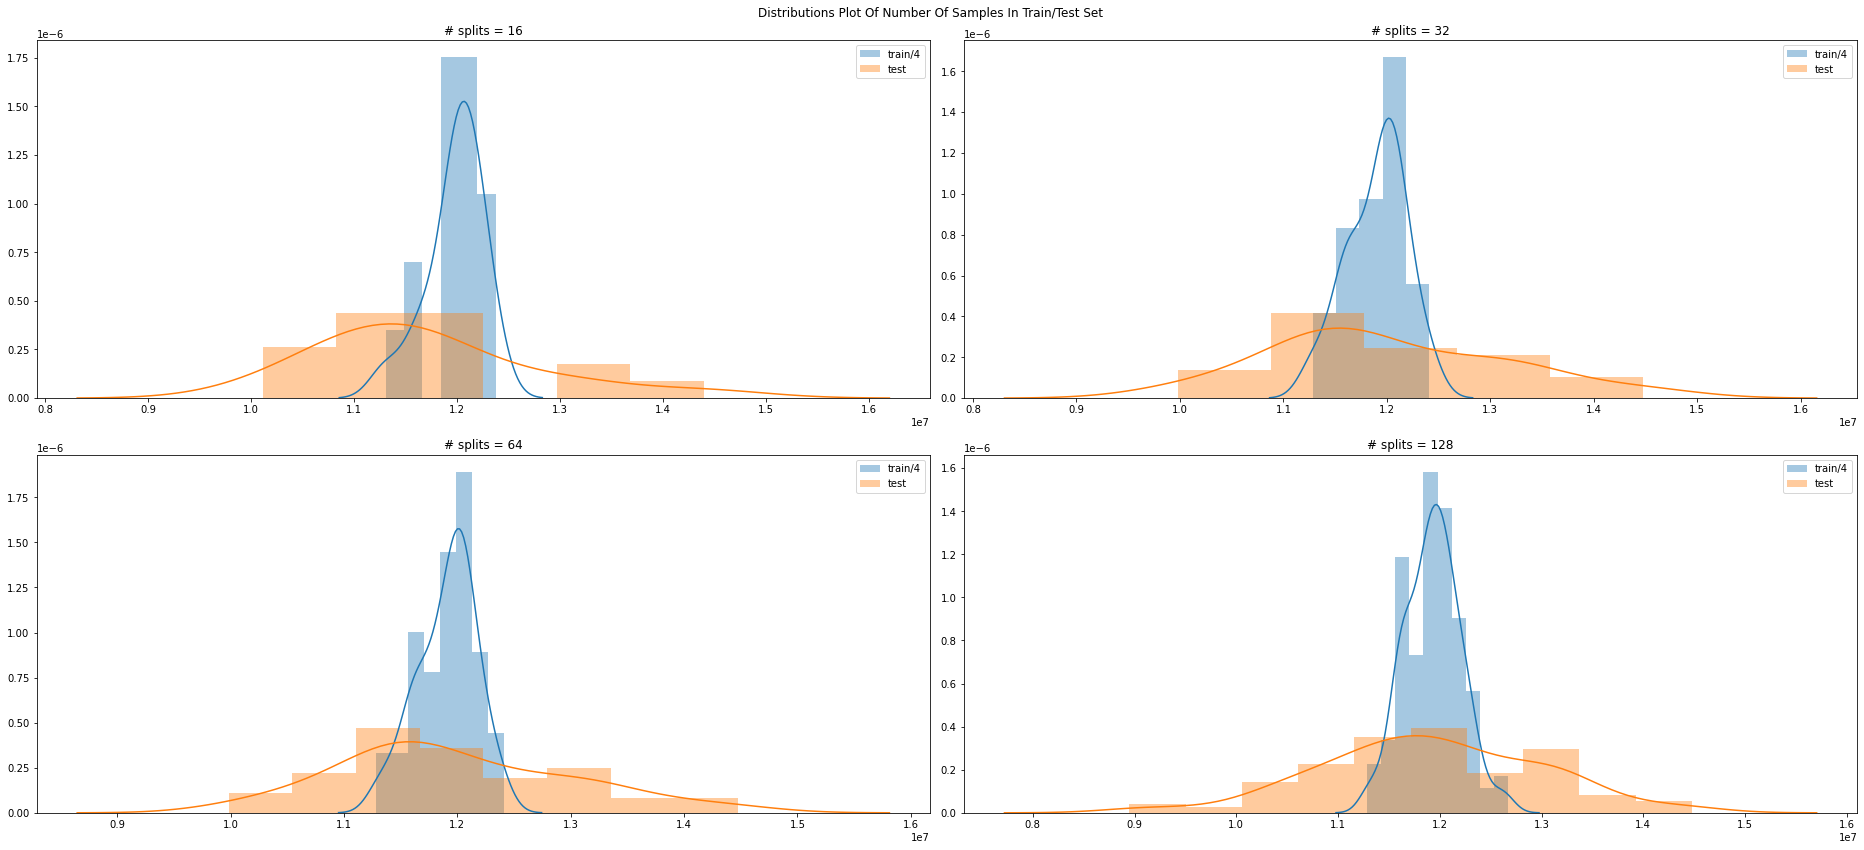

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(26,12))
splits = [16, 32, 64, 128]
for n_splits, ax in zip(splits, axes.ravel()):
    train_lens, test_lens = get_train_test_lens(n_splits)
    sns.distplot(train_lens, ax=ax, label='train/4')
    sns.distplot(test_lens, ax=ax, label='test')
    ax.set_title("# splits = {}".format(n_splits))
    ax.legend()
fig.suptitle("Distributions plot of number of samples in train/test set ".title())
plt.tight_layout()
plt.show()

### From the above plots we can see that with an increasing number of splits the mean average number of samples in the train (/4) and test sets converge. It is, however, unfeasable for us to run so many stratified test/train kfolds so we shall have to acknowledge this source of noise in any following discussion of the results.